In [14]:
import pandas as pd
import datetime
import statsmodels.api as sm
from pandas_datareader import data as web
import numpy as np

# --- 1) Load data
start = datetime.datetime(2010, 1, 1)
end   = datetime.datetime.today()

houst   = web.DataReader("HOUST",        "fred", start, end)  # monthly data
permit  = web.DataReader("PERMIT",       "fred", start, end)  # monthly data
mort30  = web.DataReader("MORTGAGE30US", "fred", start, end)  # weekly data



<Axes: title={'center': '30-Year Fixed Rate Mortgage Average in the United States '}, xlabel='DATE'>

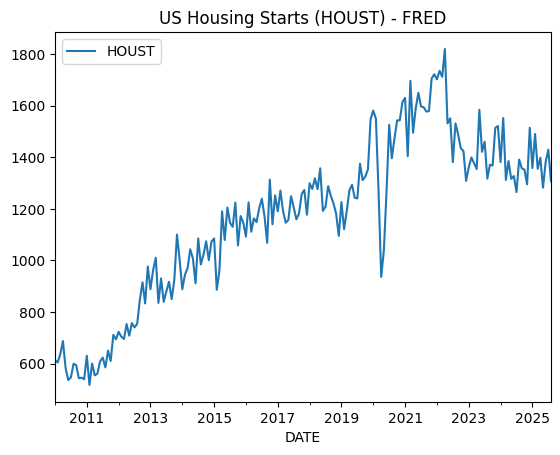

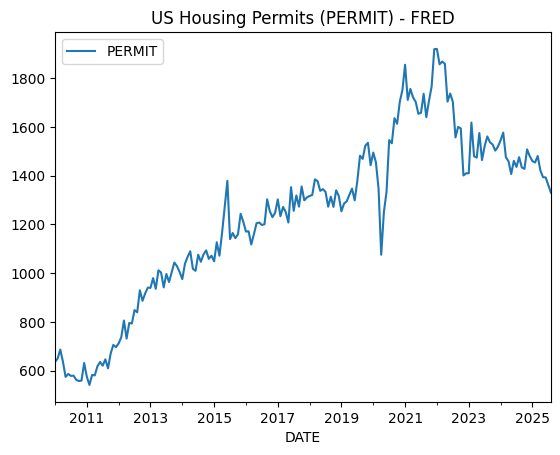

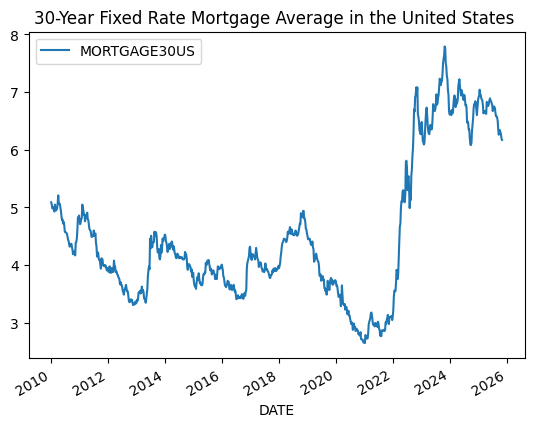

In [17]:
houst.plot(title="US Housing Starts (HOUST) - FRED")

permit.plot(title="US Housing Permits (PERMIT) - FRED")

mort30.plot(title="30-Year Fixed Rate Mortgage Average in the United States ")

NaNs per column:
 houst     0
permit    0
mort      0
dtype: int64
Index freq: MS
             houst  permit    mort
DATE                              
2025-06-01  1382.0  1393.0  6.8175
2025-07-01  1429.0  1362.0  6.7200
2025-08-01  1307.0  1330.0  6.5875


/Users/ye/opt/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  houst   No. Observations:                  187
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1064.535
Date:                Thu, 06 Nov 2025   AIC                           2141.070
Time:                        09:17:52   BIC                           2160.360
Sample:                    02-01-2010   HQIC                          2148.889
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.6000      0.274      5.841      0.000       1.063       2.137
permit_lag1     0.6865      0.042     16.437      0.000       0.605       0.768
mort          -29.4915      6.260     -4.711    

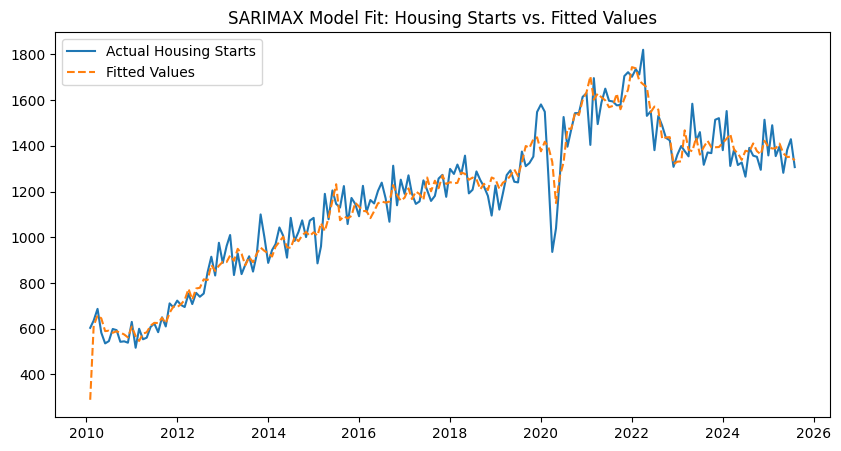

In [18]:


# --- 2) Put everything on the same monthly start index, align, and clean

mort30_m = mort30.resample("MS").mean().ffill()  # avoid NaN at the edges

df = (
    pd.concat([
        houst.rename(columns={"HOUST":"houst"}).asfreq("MS"),
        permit.rename(columns={"PERMIT":"permit"}).asfreq("MS"),
        mort30_m.rename(columns={"MORTGAGE30US":"mort"})
    ], axis=1)
    .sort_index()
)

# 3) Clean: drop inf, then drop NaNs (or ffill if you prefer)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# (Optional) sanity checks before modeling
print("NaNs per column:\n", df.isna().sum())
print("Index freq:", pd.infer_freq(df.index))
print(df.tail(3))


# Create lagged permit variable
df["permit_lag1"] = df["permit"].shift(1)

# Drop rows where lag is NaN (first observation)
df = df.dropna()

# Endogenous and exogenous variables
y = df["houst"]
X = df[["permit_lag1", "mort"]]

# Fit SARIMAX (same as before)
mod = sm.tsa.SARIMAX(
    endog=y, exog=X,
    order=(1,1,1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = mod.fit(disp=False)
print(res.summary())

# Forecast (using last known exog as proxy)
exog_next = X.iloc[[-1]].copy()
exog_next.index = pd.date_range(X.index[-1] + pd.offsets.MonthBegin(), periods=1, freq="MS")

fc = res.get_forecast(steps=1, exog=exog_next)
point = float(fc.predicted_mean.iloc[0])
lo, hi = fc.conf_int().iloc[0].tolist()

print(f"Next-month HOUST forecast: {point:,.0f} SAAR")
print(f"95% conf. interval: [{lo:,.0f}, {hi:,.0f}]")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y, label='Actual Housing Starts')
plt.plot(res.fittedvalues, label='Fitted Values', linestyle='--')
plt.legend()
plt.title("SARIMAX Model Fit: Housing Starts vs. Fitted Values")
plt.show()

# # --- 3) Fit SARIMAX (ARIMAX equivalent) with exogenous variables
# # Using d=1 (order=(1,1,1)) like before; turn off strict stationarity checks
# mod = sm.tsa.SARIMAX(
#     endog=y, exog=X,
#     order=(1,1,1),
#     trend="c",
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# res = mod.fit(disp=False)

# # --- 4) Forecast next month
# # Build a 1-row exog for the NEXT month; if you don't have forward values,
# # you can use the latest known values as a simple nowcast proxy.
# exog_next = X.iloc[[-1]].copy()
# exog_next.index = pd.date_range(X.index[-1] + pd.offsets.MonthBegin(), periods=1, freq="MS")

# fc = res.get_forecast(steps=1, exog=exog_next)
# point = float(fc.predicted_mean.iloc[0])
# lo, hi = fc.conf_int().iloc[0].tolist()

# print(f"Next-month HOUST forecast: {point:,.0f} SAAR")
# print(f"95% conf. interval: [{lo:,.0f}, {hi:,.0f}]")
